In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import os
import pathlib
import random
import sys

# 3rd party libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
from sklearn.cluster import DBSCAN

# Local libraries
import pudl

In [3]:
sns.set()
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,4)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Define Functions

## Calculation Functions

In [5]:
def calculate_ramp_rates(
    df,
    gb_cols=["plant_id_eia", "unitid"],
    min_operating_time_hours=1.0,
    min_load_factor=0.0,
    max_load_factor=1.0,
    min_load_quantile=0.0,
    max_load_quantile=1.0,
    ramp_rate_quantile=0.999,
):
    """
    Estimate the maximum hourly ramp rate observed during normal operations.
    
    The hours that are considered "normal operations" are selected based on
    both the fraction of total capacity (MW) they report in gross load, and
    on the quantile of the load reported. Boolean columns are added with flags
    indicating whether a record passes these filters.
    
    First, records are screened based on how much of an hour they represent.
    Typically only full hours (operating_time_hours==1.0) should be included.
    (valid_operating_time_hours = True)

    Then, data is included or excluded based on the load_factor. For example,
    if min_load_factor is 0.05 (5%) then any hour where the gross load is less
    than 5% of the unit's maximum observed load will be excluded. Points with
    zero gross_load_mw are always excluded. (valid_load_factor = True)
    
    Records which remain after being filtered based on load_factor are then
    filtered based on load_quantile. E.g. min_load_quantile is 0.05 (5%) then
    the remaining records with the lowest 5% of all reported gross_load_mw
    values will be excluded. (valid_load_quantile = True)
    
    Once the data has been flagged, we take the absolute value of the
    difference between adjacent hours on a per-unit basis, and then use
    ramp_rate_quantile to identify the largest reasonable ramp rate
    from the distribution of observed ramp rates. E.g. if max_rate_quantile
    is 0.99, then we take the 99th percentile of the observed ramp rates as
    a reasonable estimate for the maximum ramp rate.
    
    
    """
    df = df.assign(
        # Normally only use data from full hours of operation.
        valid_operating_time_hours=lambda x: (
            x.operating_time_hours >= min_operating_time_hours
        ),
        load_factor=lambda x: (
            x.groupby(gb_cols)["gross_load_mw"].transform(lambda x: x / x.max())
        ),
        valid_load_factor=lambda x: (
            (x.load_factor > 0.0)
            & (x.load_factor >= min_load_factor)
            & (x.load_factor <= max_load_factor)
        ),
        # Create a new column including only the records whose load factors
        # we want to filter using the load quantile. Lots of plants have a
        # bunch of hours that are right at 0.0 MW, or close to it, which 
        # aren't really part of the overall operational profile of the plant.
        load_factor_to_rank=lambda x: np.where(
            (x.valid_operating_time_hours) & (x.valid_load_factor),
            x.load_factor,
            np.nan,
        ),
        load_quantile=lambda x: (
            x.groupby(gb_cols)["load_factor_to_rank"].rank(method="first", pct=True)
        ),
        valid_load_quantile=lambda x: (
            (x.load_quantile >= min_load_quantile)
            & (x.load_quantile <= max_load_quantile)
        ),
        valid_gross_load_mw=lambda x: np.where(
            x.valid_load_quantile,
            x.gross_load_mw,
            np.nan
        ),
        hourly_ramp_mw=lambda x: (
            x.sort_values(gb_cols + ["operating_datetime_utc"])
            .groupby(gb_cols)["valid_gross_load_mw"]
            .diff().abs()
        ),
        max_ramp_mw=lambda x: (
            x.groupby(gb_cols)["hourly_ramp_mw"]
            .transform(lambda x: x.quantile(ramp_rate_quantile))
        ),
        hourly_ramp_factor=lambda x: (
            x.groupby(gb_cols, as_index=False)
            .apply(lambda x: x.hourly_ramp_mw / x.gross_load_mw.max())
            .reset_index(level=0, drop=True)
        ),
        max_ramp_factor=lambda x: (
            x.groupby(gb_cols)["hourly_ramp_factor"].transform(max)
        ),
    )
    return df

## Visualization Functions

In [6]:
def plot_load_outliers(df, col, unit_label=""):
    """
    Time vs. Gross Load, highlighting which points are used to calculate max ramp rates.
    """
    sns.scatterplot(
        x="operating_datetime_utc",
        y="gross_load_mw",
        data=df, hue=col,
        linewidth=0, s=3, alpha=0.25,
        palette=["red", "black"],
    )
    plt.title(f"Ramp Rate Load Outliers; Unit: {unit_label}; Max Ramp: {df.max_ramp_mw.max():.2f}MW")
    plt.legend(loc="lower left", title=col)
    plt.show();


def plot_load_cum_dist(df, col, unit_label="", cumulative=True, log=True):
    """
    Cumulative histogram showing load cutoffs.
    """
    min_valid_load = df[df[col]].gross_load_mw.min()
    max_valid_load = df[df[col]].gross_load_mw.max()
    tmp_df = df[
        (df.gross_load_mw > 0.0)
    ]
    
    plt.hist(
        tmp_df.gross_load_mw,
        bins=100,
        log=log,
        cumulative=cumulative,
        range=(0, tmp_df.gross_load_mw.max())
    )
    plt.axvline(x=min_valid_load, lw=2, color="black")
    plt.axvline(x=max_valid_load, lw=2, color="black")
    plt.ylabel("Hours")
    plt.xlabel("Gross Load [MW]")
    plt.title(f"Distribution of Gross Hourly Load; Unit: {unit_label}")
    plt.show()

def plot_load_factor_quantile(df, alpha=0.25):
    """
    The relationship between load quantile and load factor.
    
    Must represent a single unit such that load factor is monotonically
    increasing as a function of load quantile.

    """
    tmp_df = df.sort_values("load_quantile")
    plt.plot(
        tmp_df.load_quantile,
        tmp_df.load_factor,
        lw=2, alpha=alpha, color="black",
    )

# Define Notebook Parameters

In [7]:
pudl_settings = pudl.workspace.setup.get_defaults()
ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])

CEMS_PATH = pathlib.Path(pudl_settings["parquet_dir"]) / "epacems"

CEMS_STATES = ["CO",]
CEMS_YEARS = [2019]
CEMS_COLS = [
    "plant_id_eia",
    "unitid",
    "operating_datetime_utc",
    "operating_time_hours",
    "gross_load_mw",
#   "co2_mass_tons",
#   "co2_mass_measurement_code",
#   "heat_content_mmbtu",
#   "facility_id",
#   "unit_id_epa",
    "year",
    "state"
]

GB_COLS = ["plant_id_eia", "unitid", "year"]
MIN_OPERATING_TIME_HOURS = 1.0
MIN_LOAD_FACTOR = 0.025
MAX_LOAD_FACTOR = 1.0
MIN_LOAD_QUANTILE = 0.025
MAX_LOAD_QUANTILE = 0.975
RAMP_RATE_QUANTILE = 0.99

# Load Data

## Load EPA CEMS Hourly from Apache Parquet

In [8]:
%%time

colo_cems = pd.read_parquet(
    CEMS_PATH,
    use_nullable_dtypes=True,
    columns=CEMS_COLS,
    filters=pudl.output.epacems.year_state_filter(
        states=CEMS_STATES,
        years=CEMS_YEARS,
    )
)

CPU times: user 142 ms, sys: 82.3 ms, total: 224 ms
Wall time: 214 ms


# Data Analysis and Visualization

In [9]:
%%time

max_ramps = calculate_ramp_rates(
    colo_cems,
    gb_cols=GB_COLS,
    min_operating_time_hours=MIN_OPERATING_TIME_HOURS,
    min_load_factor=MIN_LOAD_FACTOR,
    max_load_factor=MAX_LOAD_FACTOR,
    min_load_quantile=MIN_LOAD_QUANTILE,
    max_load_quantile=MAX_LOAD_QUANTILE,
    ramp_rate_quantile=RAMP_RATE_QUANTILE,
)

CPU times: user 1.31 s, sys: 151 ms, total: 1.46 s
Wall time: 1.45 s


## Excluding abnormal operations
* We want to base our estimate of ramp rate on the operation of plants which are already running.
* Only use hours where the plant was running for the entire hour (`MIN_OPERATING_TIME_HOURS==1`).
* Many plants report a lot of hours with zero output. We can clip them by ignoring the lowest few percent of the unit's total operational range (by setting `MIN_LOAD_FACTOR` to e.g. 0.025). Depending on the unit, this may be a substantial fraction of the overall data reported, but since it's all at or very close to zero output, we know it won't affect the total avaialble range of ramping much.
* Many plants have a range of output that is sparsely populated between zero and their normal operations. Clip it out by ignoring the bottom few percent of all remaining data points (by setting `MIN_LOAD_QUANTILE` to e.g. 0.025).
* In practice this sometimes removes a few points from the main distribution of data, which represents normal operations, but it generally preserves the full dynamic range of ramping that appears in that distribution.
* Similarly we can remove any unrepresentative output spikes above the normal operations (by setting `MAX_LOAD_QUANTILE` to something like 0.975)
* These limits can be applied to the entire time series, or to certain blocks within it (like full years) since the distribution shifts up and down for many plants over time (This is controlled by `GB_COLS`)

### Inspect Random Units
* Sanity check the above data selection process by looking at the full time series for a few units, and color coding the points according to whether they labeled for retention in the ramp rate calculation.
* **TODO:** Create a categorical column based on the boolean filter columns which can be used to label / color points differently based on different reasons why they were excluded, in order of precedence:
  * Not a full hour of operations.
  * Not in the acceptable range of LOAD_FACTOR values
  * Not in the acceptable range of LOAD_QUANTILE values.

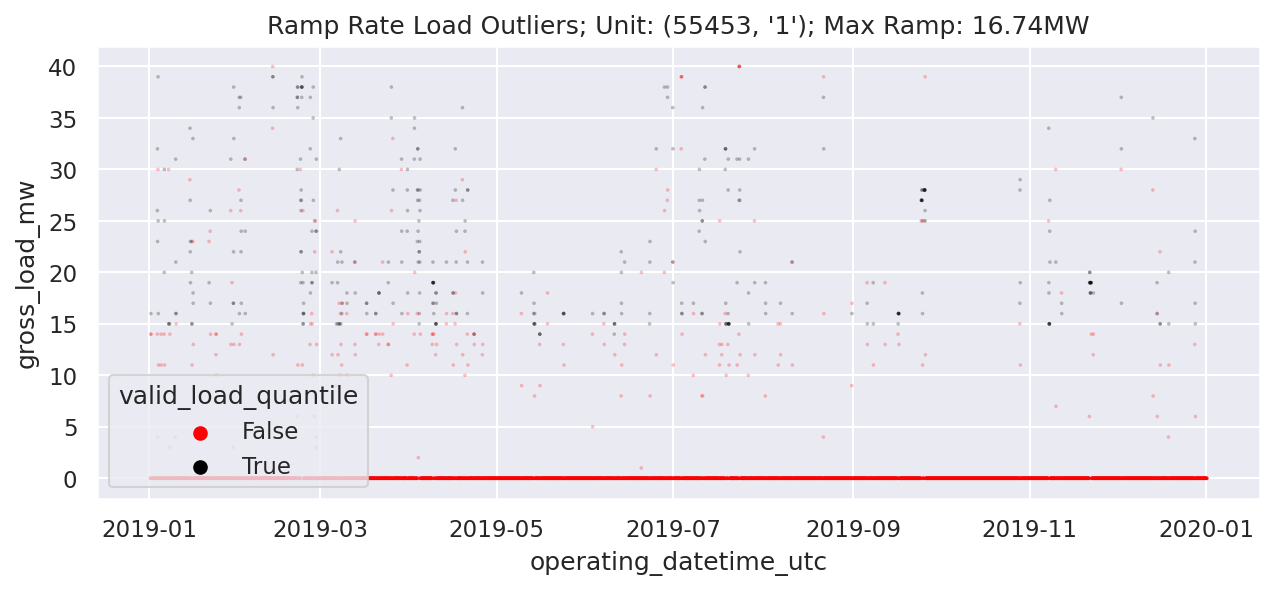

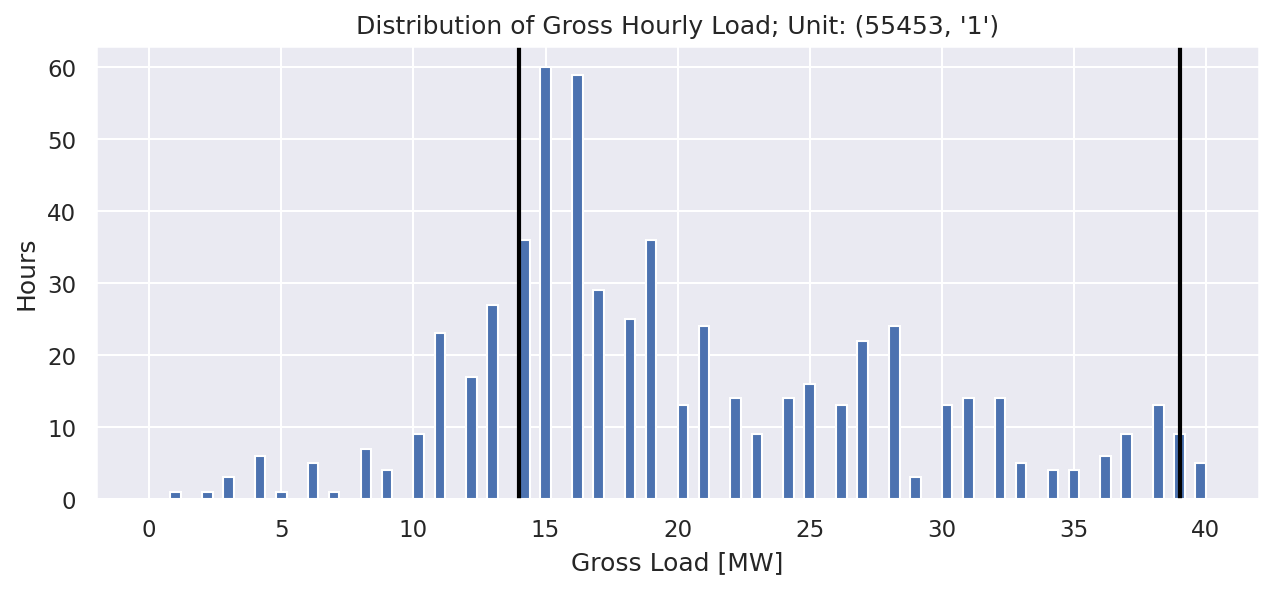

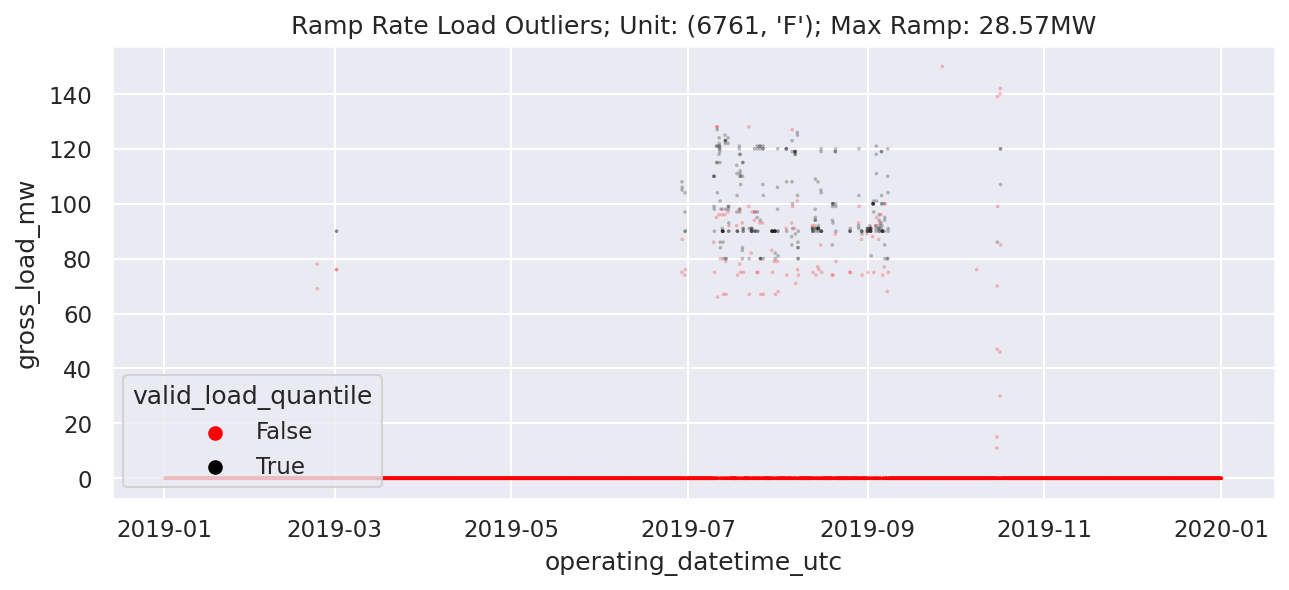

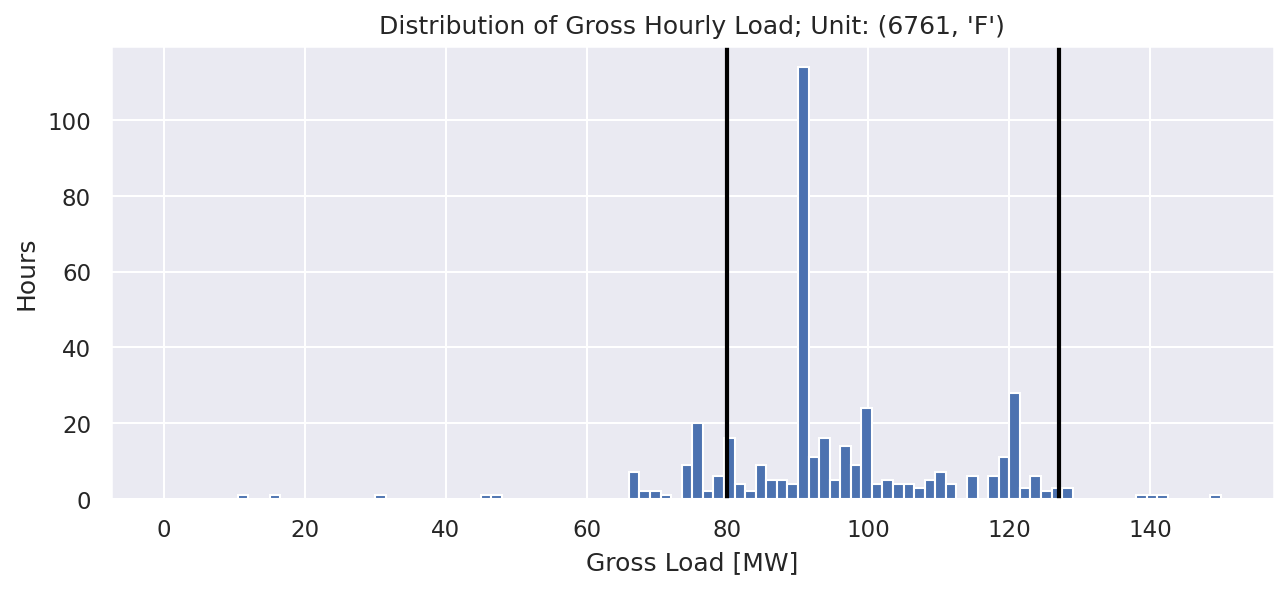

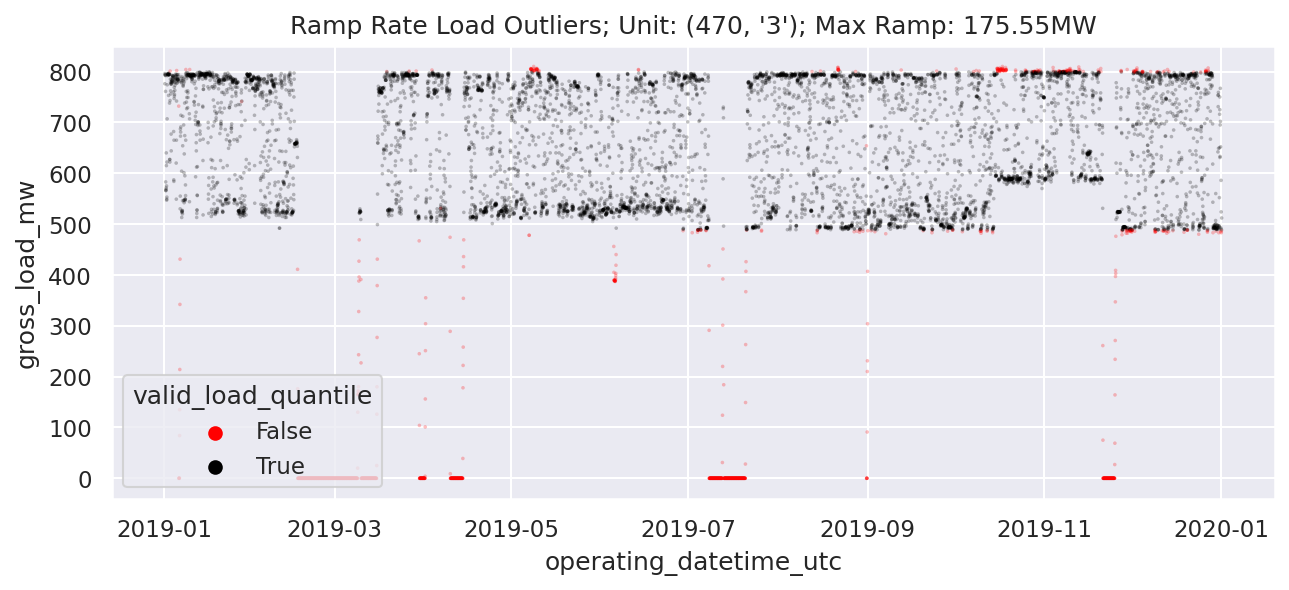

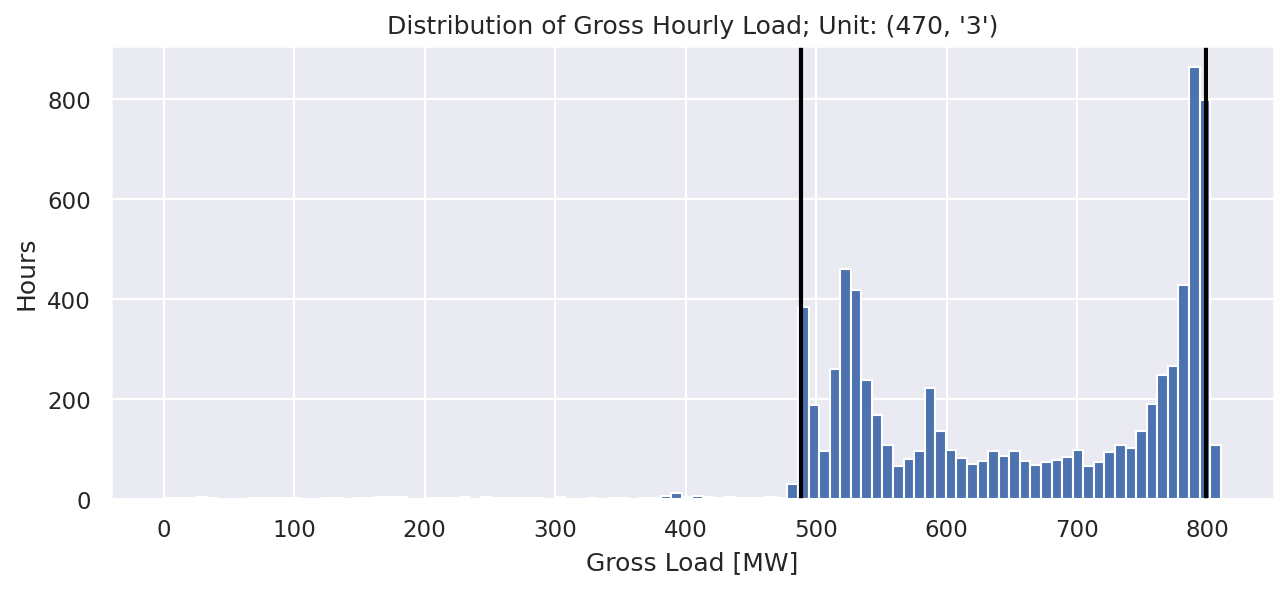

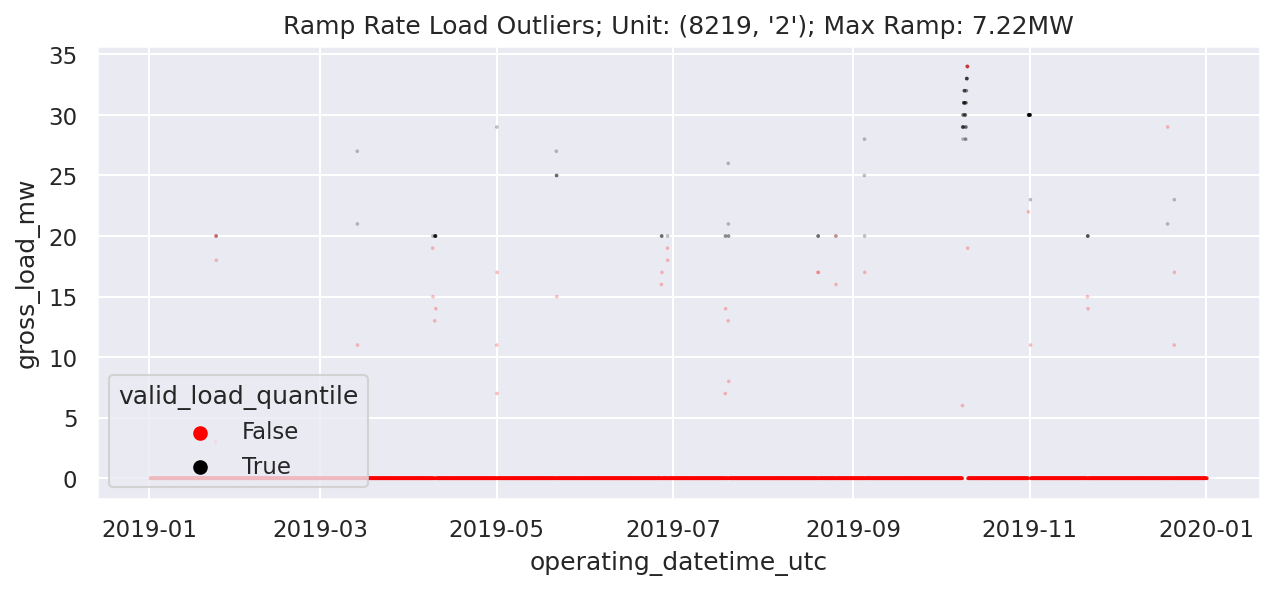

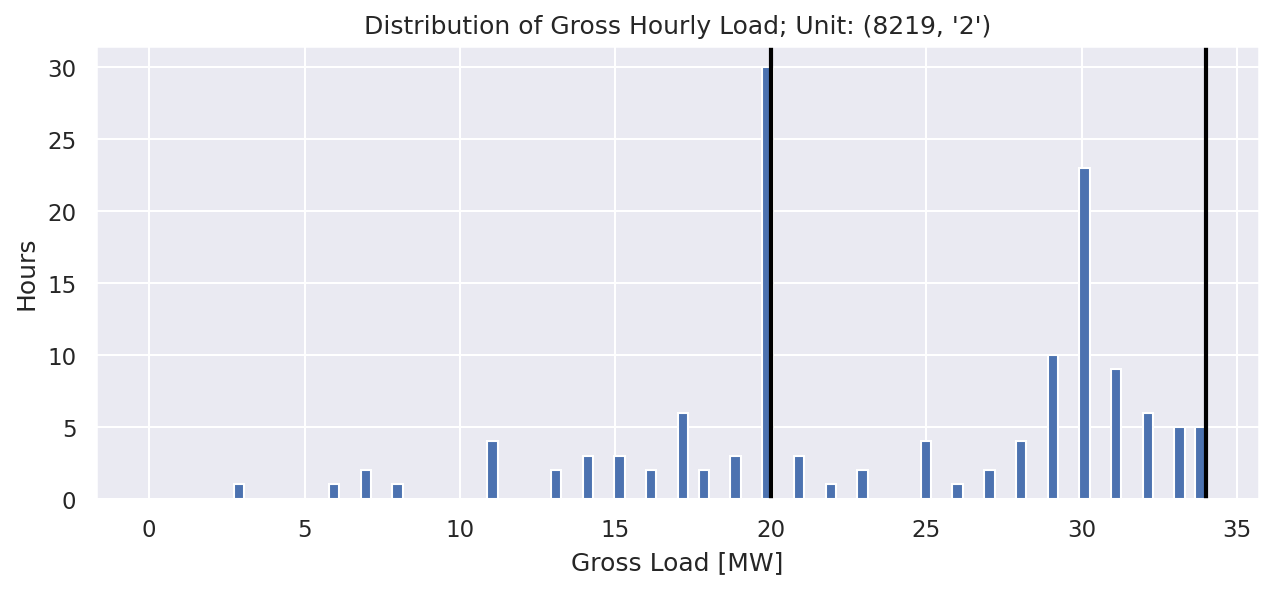

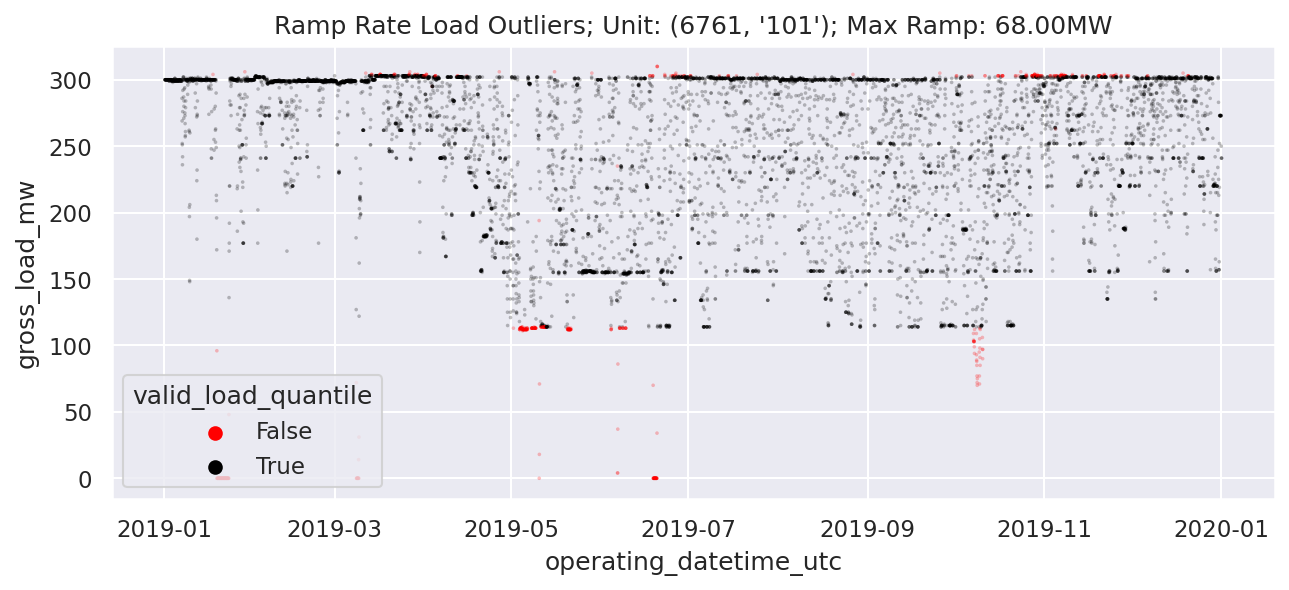

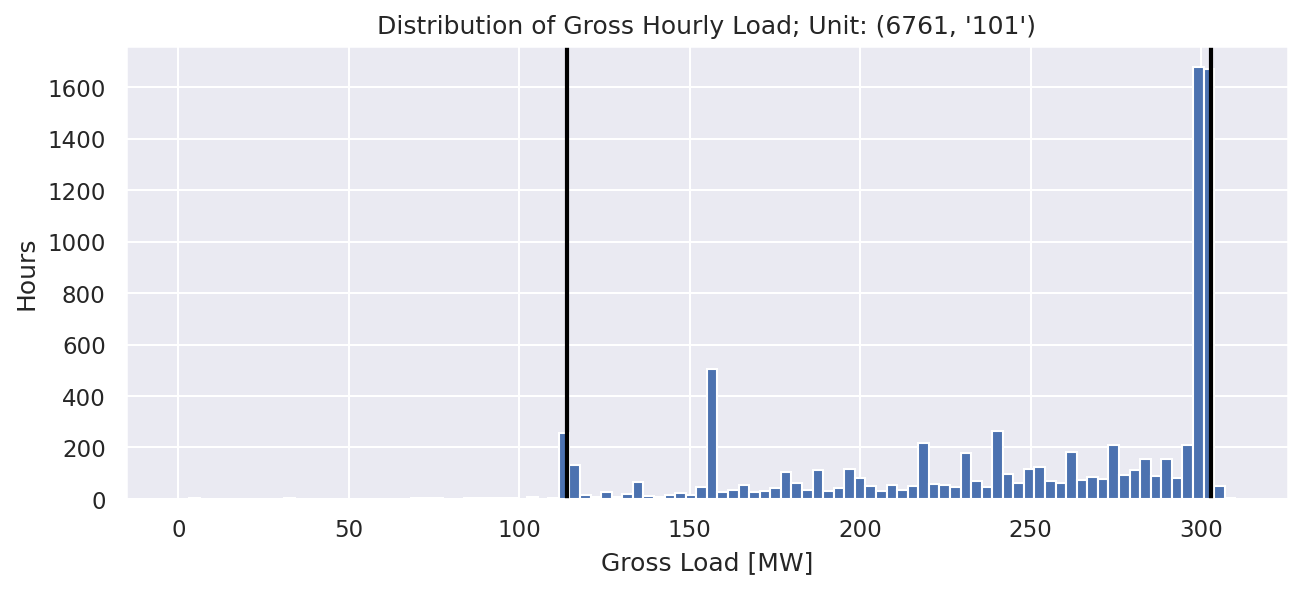

CPU times: user 6.31 s, sys: 441 ms, total: 6.75 s
Wall time: 5.91 s


In [10]:
%%time
group_ids = list(max_ramps.groupby(["plant_id_eia", "unitid"]).groups.keys())
random_units = random.sample(group_ids, k=5)

for unit in random_units:
    df=max_ramps.set_index(GB_COLS).sort_index().loc[unit]
    
    plot_load_outliers(
        df=df,
        col="valid_load_quantile",
        unit_label=unit,
    )

    plot_load_cum_dist(
        df=df,
        col="valid_load_quantile",
        unit_label=unit,
        cumulative=False,
        log=False,
    )

<AxesSubplot:xlabel='operating_datetime_utc'>

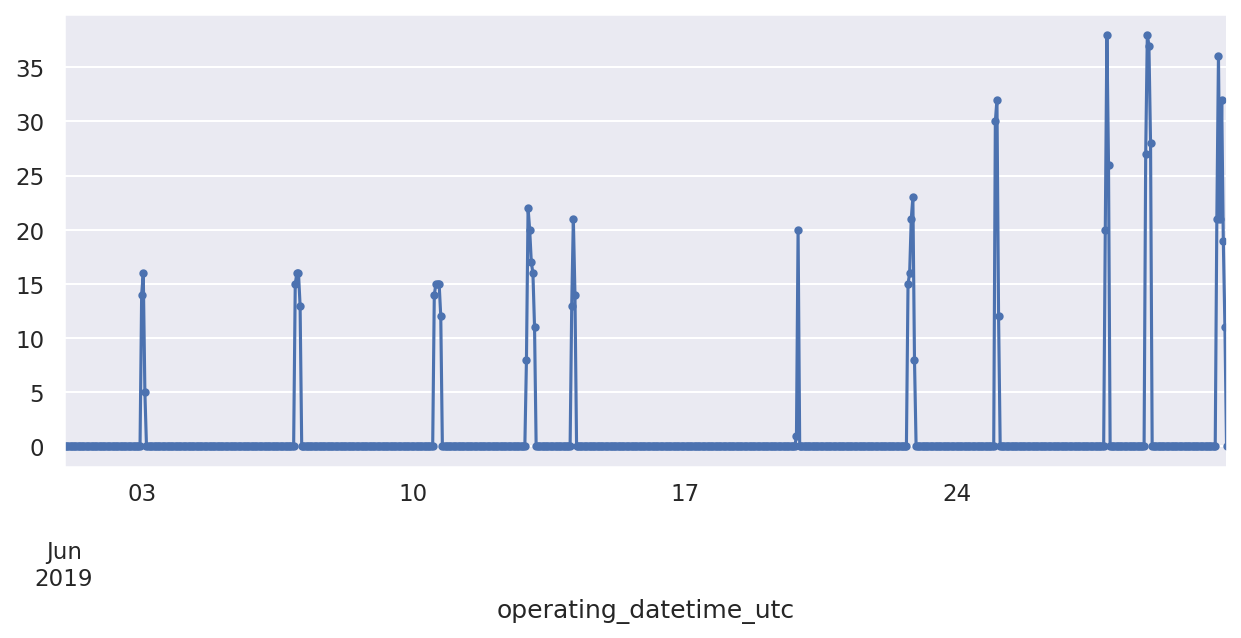

In [22]:
unit = random_units[0]
df=max_ramps.set_index(GB_COLS).sort_index().loc[unit]
df = df.set_index('operating_datetime_utc')
df.loc['2019-06-01':'2019-06-30', 'gross_load_mw'].plot(marker='.')

<AxesSubplot:xlabel='operating_datetime_utc'>

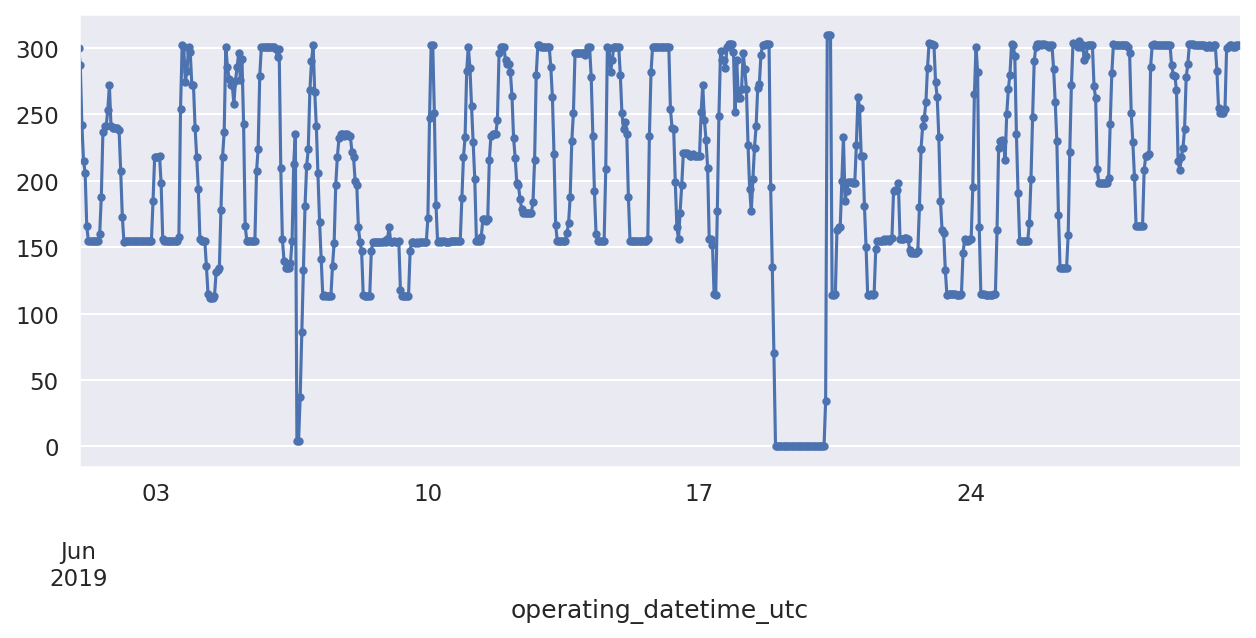

In [23]:
unit = random_units[4]
df=max_ramps.set_index(GB_COLS).sort_index().loc[unit]
df = df.set_index('operating_datetime_utc')
df.loc['2019-06-01':'2019-06-30', 'gross_load_mw'].plot(marker='.')

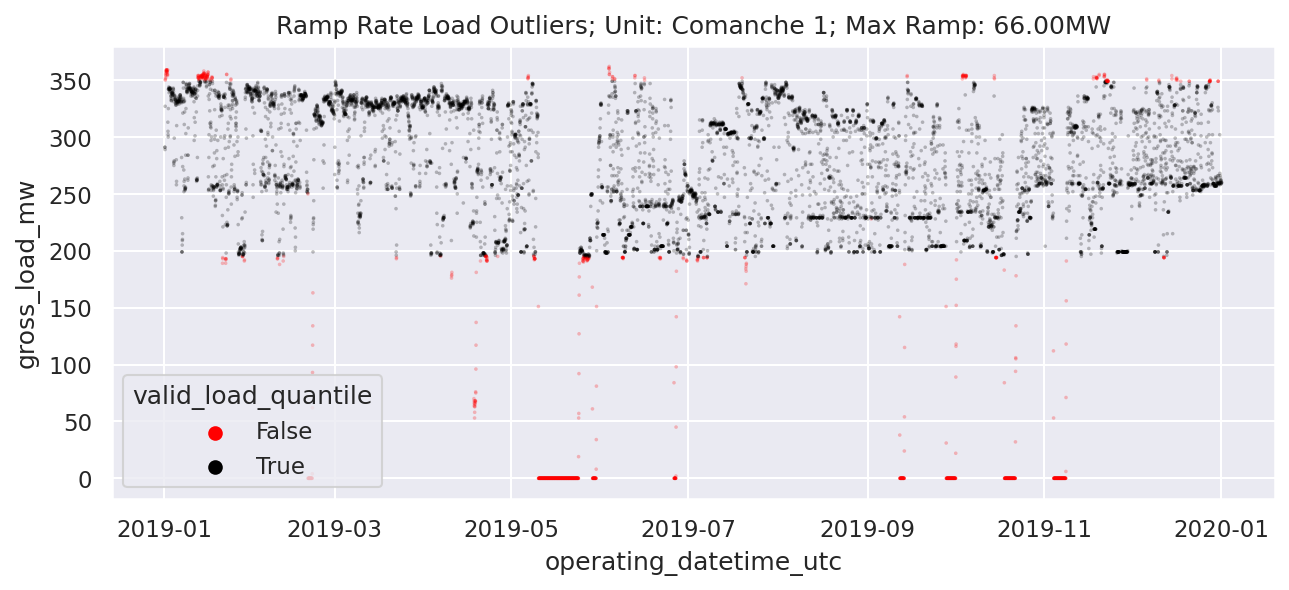

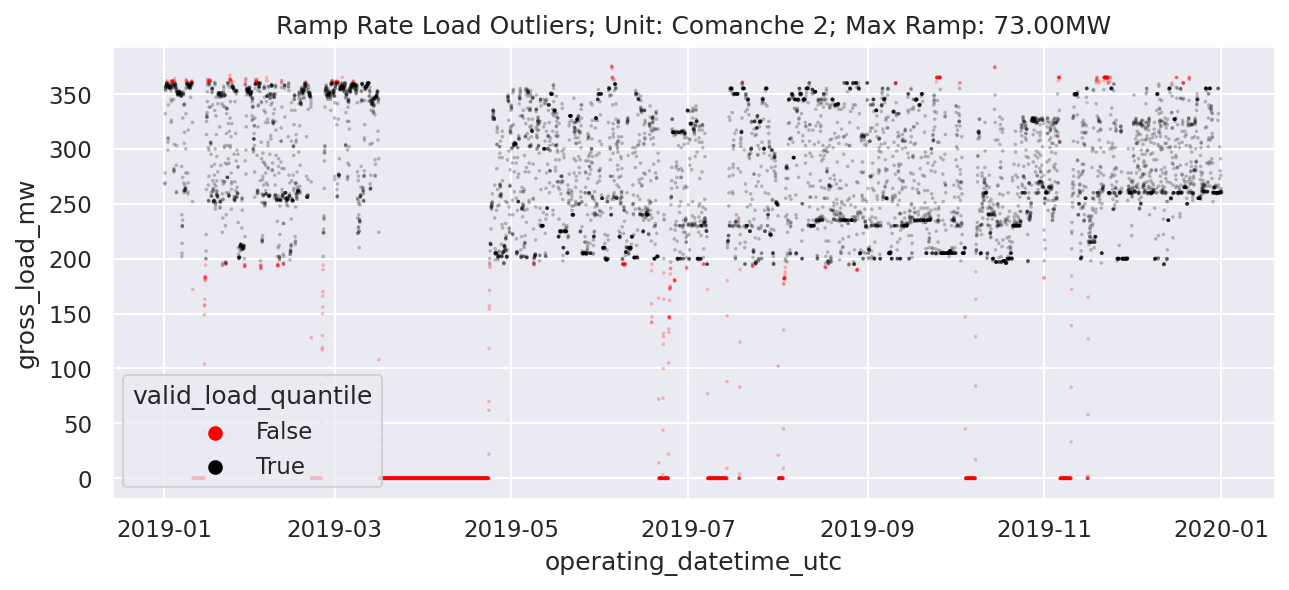

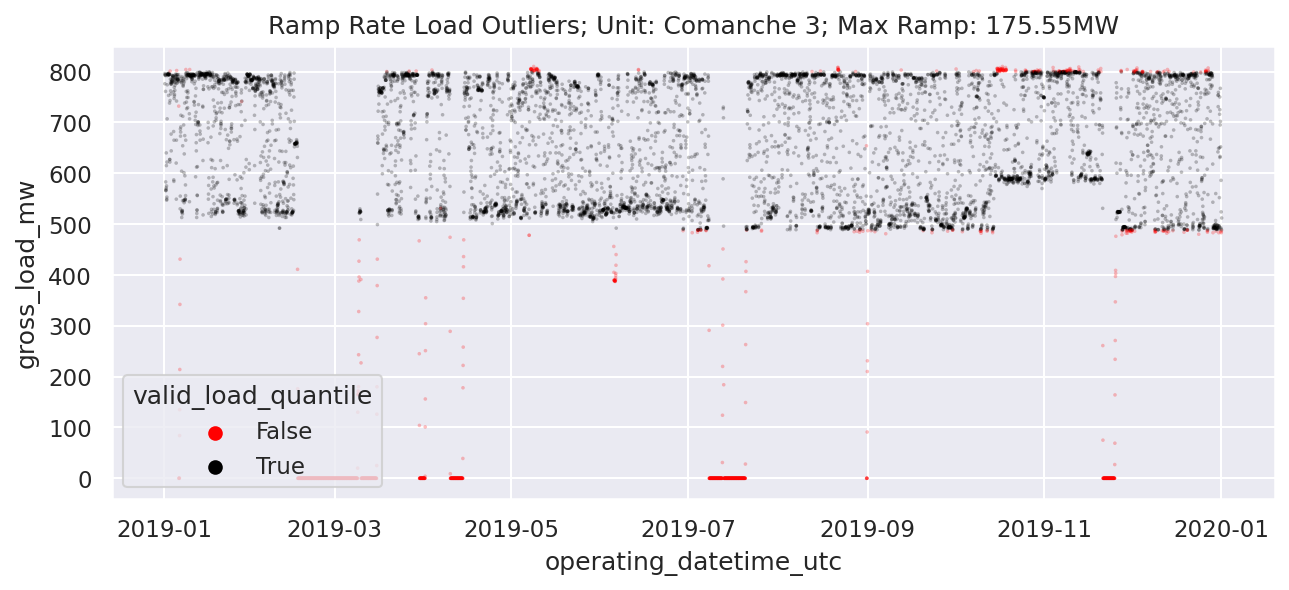

In [13]:
if "CO" in CEMS_STATES:
    plot_load_outliers(max_ramps.set_index(GB_COLS).sort_index().loc[(470, "1")], col="valid_load_quantile", unit_label="Comanche 1")
    plot_load_outliers(max_ramps.set_index(GB_COLS).sort_index().loc[(470, "2")], col="valid_load_quantile", unit_label="Comanche 2")
    plot_load_outliers(max_ramps.set_index(GB_COLS).sort_index().loc[(470, "3")], col="valid_load_quantile", unit_label="Comanche 3")

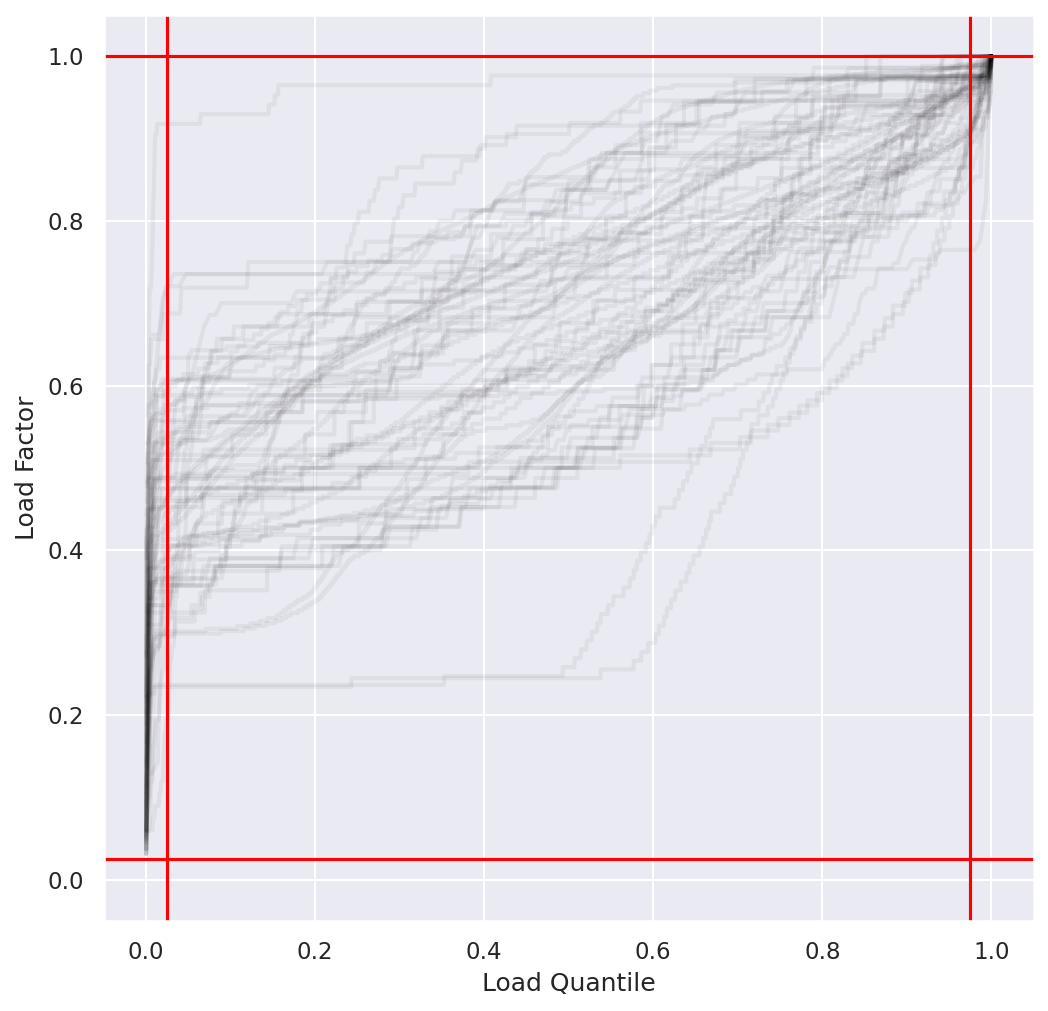

In [14]:
plt.figure(figsize=(8, 8))

gb = max_ramps.groupby(GB_COLS)

for unit in gb.groups:
    plot_load_factor_quantile(gb.get_group(unit), alpha=0.05)

plt.axhline(MIN_LOAD_FACTOR, color="red")
plt.axhline(MAX_LOAD_FACTOR, color="red")
plt.axvline(MIN_LOAD_QUANTILE, color="red")
plt.axvline(MAX_LOAD_QUANTILE, color="red")
plt.xlabel("Load Quantile")
plt.ylabel("Load Factor")
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.show()

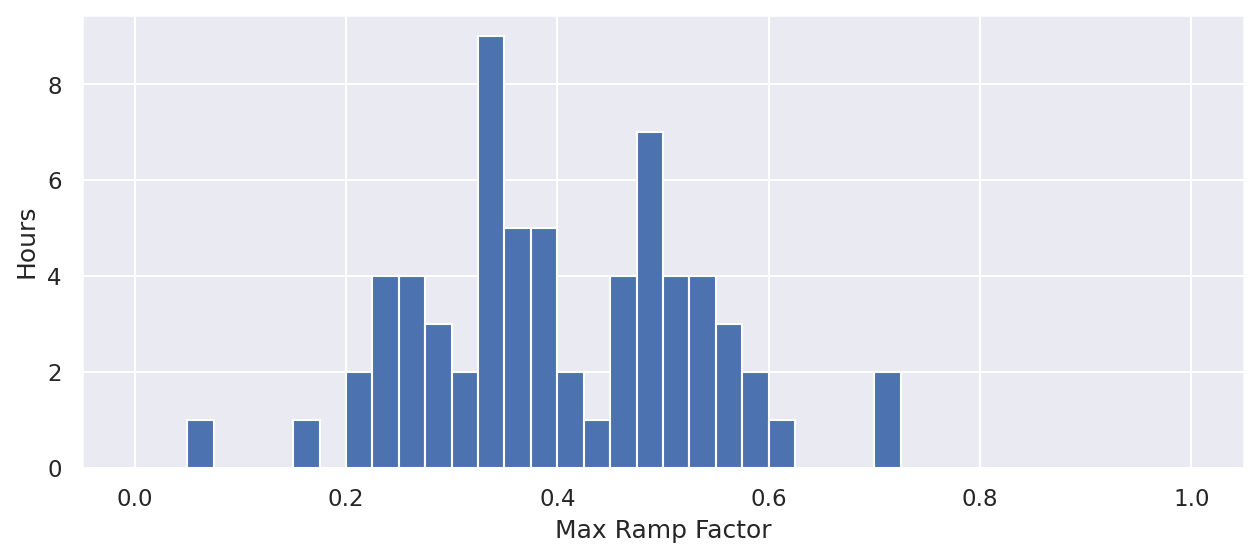

In [15]:
plt.hist(max_ramps.groupby(GB_COLS)["max_ramp_factor"].max().replace(0, np.nan), bins=40, range=(0,1));
plt.xlabel("Max Ramp Factor")
plt.ylabel("Hours");

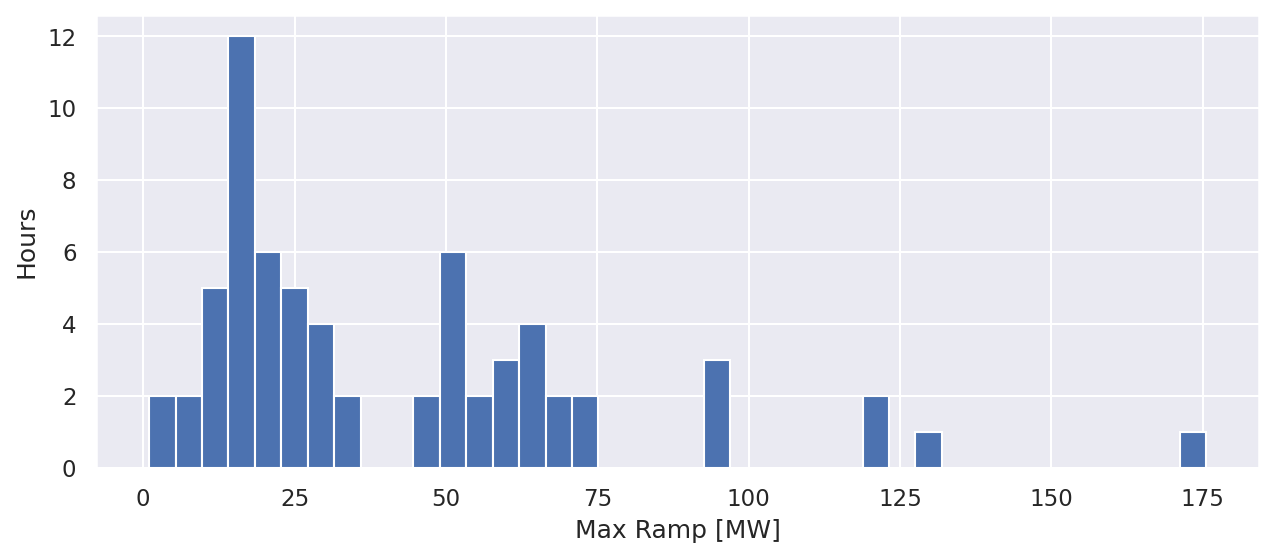

In [16]:
plt.hist(max_ramps.groupby(GB_COLS)["max_ramp_mw"].max().replace(0, np.nan), bins=40);
plt.xlabel("Max Ramp [MW]")
plt.ylabel("Hours");

In [17]:
list(max_ramps.columns)

['plant_id_eia',
 'unitid',
 'operating_datetime_utc',
 'operating_time_hours',
 'gross_load_mw',
 'year',
 'state',
 'valid_operating_time_hours',
 'load_factor',
 'valid_load_factor',
 'load_factor_to_rank',
 'load_quantile',
 'valid_load_quantile',
 'valid_gross_load_mw',
 'hourly_ramp_mw',
 'max_ramp_mw',
 'hourly_ramp_factor',
 'max_ramp_factor']

<Figure size 1500x1500 with 0 Axes>

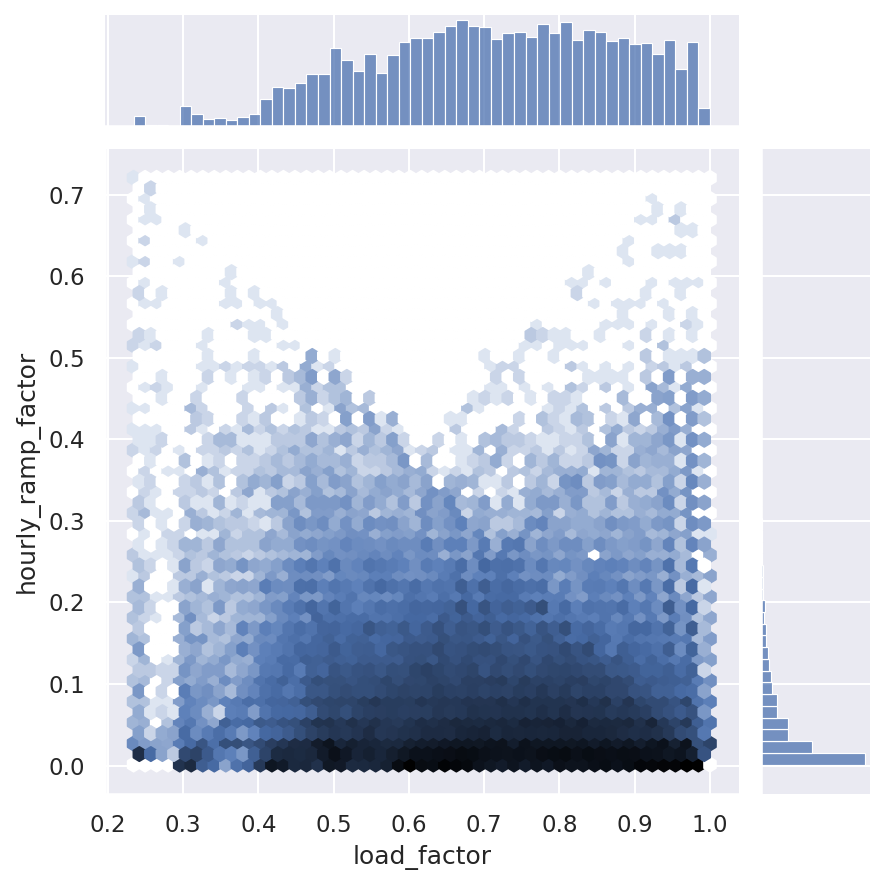

In [18]:
plt.figure(figsize=(10,10))
sns.jointplot(
    x="load_factor",
    y="hourly_ramp_factor",
    data=max_ramps.replace(to_replace={"hourly_ramp_factor": 0.0}, value=np.nan),
    kind="hex",
    bins="log",
    marginal_kws={"bins": 50}
);

In [19]:
filter_cols = [
    "plant_id_eia",
    "unitid",
    "operating_datetime_utc",
    "valid_operating_time_hours", # Full hours only
    "valid_load_factor", # between min/max load factor
    "valid_load_quantile", # between min/max load quantile
    "why_excluded",
]
max_ramps["why_excluded"] = pd.Series(data=pd.NA, dtype=pd.StringDtype())
(
    max_ramps[filter_cols].loc[
        (~max_ramps.valid_load_quantile)
    ].sample(20)
)


,plant_id_eia,unitid,operating_datetime_utc,valid_operating_time_hours,valid_load_factor,valid_load_quantile,why_excluded
169807,6248,1,2019-04-26 14:00:00+00:00,False,False,False,<NA>
168600,6112,6,2019-04-06 07:00:00+00:00,False,False,False,<NA>
307710,56998,CT08,2019-06-01 13:00:00+00:00,False,False,False,<NA>
491125,10682,GT5,2019-10-27 20:00:00+00:00,False,False,False,<NA>
192240,55504,L1,2019-04-01 07:00:00+00:00,False,False,False,<NA>
577454,525,H1,2019-12-06 21:00:00+00:00,True,True,False,<NA>
505910,55504,L1,2019-10-23 21:00:00+00:00,False,False,False,<NA>
274656,6761,A,2019-06-04 07:00:00+00:00,False,False,False,<NA>
67219,6112,6,2019-02-13 02:00:00+00:00,False,False,False,<NA>
494972,55127,CT1,2019-10-02 03:00:00+00:00,False,False,False,<NA>


In [20]:

assert False

AssertionError: 